# Deep Fruit Vision Evaluation

Our detection, ripeness, and defect models are all trained and tested on different datasets. This notebook evaluates the overall performance of Deep Fruit Vision on a unique, hand-labelled test dataset.

In [10]:
import os

from tqdm.notebook import tqdm
import torch
from deepfruitvision import DeepFruitVision
from modules.datasets import TestDataset, save_dataset
from yolov5.val import process_batch

import matplotlib
from matplotlib import pyplot as plt

%matplotlib inline

In [11]:
detection_weights = os.path.join('weights', 'detection', 'best.pt')
ripeness_weights = os.path.join('weights', 'ripeness', 'ripeness_model')
defect_weights = os.path.join('weights', 'disease', 'defect_model')

We can use the TestDataset class to easily load images and labels from the test dataset.

In [12]:
test_dataset = TestDataset('dataset')

## Detection mAP

The detection/Yolo-v5 model is responsible for detecting and classifying fruits, so we can just use Yolo-v5's built-in evaluation script.

In [13]:
test_dataset.for_yolov5_eval = True

detection_eval_img_dir = os.path.join('dataset', 'yolov5_test', 'images')
detection_eval_label_dir = os.path.join('dataset', 'yolov5_test', 'labels')

os.makedirs(detection_eval_img_dir, exist_ok=True)
os.makedirs(detection_eval_label_dir, exist_ok=True)

save_dataset(test_dataset, detection_eval_img_dir, detection_eval_label_dir)

In [14]:
!python yolov5/val.py --data apple_papaya_mango.yaml --weights {detection_weights} --img 416 --task test

In [15]:
# set this to be false now that we are done evaluating the detection model
test_dataset.for_yolov5_eval = False

## Ensemble Classification Accuracy

Now we want to evaluate the accuracy of the ensemble classification model. Since we only care about the accuracy of the harvestability, we ignore any bounding box that is too small to be classified.

In [16]:
fruit_vision = DeepFruitVision(detection_weights, ripeness_weights, defect_weights)

YOLOv5  2022-10-19 Python-3.10.5 torch-1.12.0 CUDA:0 (NVIDIA GeForce GTX 1070, 8192MiB)

Fusing layers... 
Model summary: 157 layers, 7018216 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


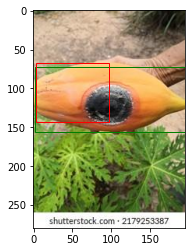

In [17]:
# use Matplotlib to display the true and predicted bounding boxes
# true bounding boxes are a list of dicts with x, y, w, and h keys (all normalized, not pixel values)
# predicted bounding boxes are a list of dicts with xmin, ymin, xmax, ymax (all normalized, not pixel values)
def display_bboxes(img, true_bboxes, pred_bboxes):
    img_h, img_w, _ = img.shape
    fig, ax = plt.subplots(1)
    ax.imshow(img)
    for bbox in true_bboxes:
        x = bbox['x'] * img_w
        y = bbox['y'] * img_h
        w = bbox['w'] * img_w
        h = bbox['h'] * img_h
        rect = matplotlib.patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='g', facecolor='none')
        ax.add_patch(rect)
    for bbox in pred_bboxes:
        x = bbox['xmin'] * img_w
        y = bbox['ymin'] * img_h
        w = (bbox['xmax'] - bbox['xmin']) * img_w
        h = (bbox['ymax'] - bbox['ymin']) * img_h
        rect = matplotlib.patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    plt.show()

for i in range(1):
    img, true_boxes = test_dataset[i]
    pred_boxes = fruit_vision.get_harvestability(img)
    display_bboxes(img, true_boxes, pred_boxes)

In [18]:
min_box_size = fruit_vision.min_bounding_box_size

total_boxes = 0
total_correct = 0

for frame, true_boxes in tqdm(test_dataset, desc='Evaluating DeepFruitVision', total=len(test_dataset)):
    predicted_boxes = fruit_vision.get_harvestability(frame)

    # ignore any boxes in the predicted and true boxes that are too small to be classified
    predicted_boxes = [box for box in predicted_boxes if box['xmax'] - box['xmin'] > min_box_size and box['ymax'] - box['ymin'] > min_box_size]
    # the true boxes are numpy arrays with the format [class, x, y, w, h, ...]
    true_boxes = [box for box in true_boxes if box['w'] > min_box_size and box['h'] > min_box_size]

    if len(true_boxes) == 0: # if there are no boxes large enough to be classified, then we can't evaluate this frame
        continue

    total_boxes += len(true_boxes)

    if len(predicted_boxes) == 0: # if there are no predicted boxes, then we automatically get 0 correct
        continue
    
    # now we have to convert the predicted and true boxes to tensors so we can use Yolo-v5's process_batch function
    # the predicted boxes need to be converted to a tensor of shape [num_boxes, 6] with the format [ x1, y1, x2, y2, conf, class] ...
    predicted_boxes = torch.tensor([[box['xmin'], box['ymin'], box['xmax'], box['ymax'], box['conf'], box['harvestability']] for box in predicted_boxes])

    # ... and the true boxes need to be converted to a tensor of shape [num_boxes, 5] with the format [class, x1, y1, x2, y2]
    true_boxes = torch.tensor([[box['ensemble'], box['x'], box['y'], box['x'] + box['w'], box['y'] + box['h']] for box in true_boxes])

    correct_boxes = process_batch(predicted_boxes, true_boxes, torch.tensor([.5]))

    total_correct += torch.sum(correct_boxes).item()

print(f'Got {total_correct} out of {total_boxes} correct ({total_correct / total_boxes * 100:.2f}%)')

Evaluating DeepFruitVision:   0%|          | 0/29 [00:00<?, ?it/s]

Got 23 out of 111 correct (20.72%)
